# OPHELIA DANKYI

# Evolving temporal classifiers

By [Marcus Ghosh](https://profiles.imperial.ac.uk/m.ghosh/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ghoshm/Evo_tutorial/blob/main/Evolving_temporal_classifiers.ipynb)

## Aim

We're going to write a simple evolutionary algorithm, and use it to solve a task.

There are 4 parts to this - which you should work on in pairs:

* Understand the **task**.
* Understand the **network** model.
* Write an **evolutionary algorithm** to optimise these models.
* **Extensions**.

Throughout instructions and questions are marked like this:

> 0. Read, code or answer a question.

For the last 30 minutes we will discuss this notebook, particularly these numbered parts.

## Setup

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import copy
!pip install netgraph
from netgraph import Graph

import os

# For Google Colab
if not os.path.exists('src.py'):
  !git clone https://github.com/ghoshm/Evo_tutorial.git
  %cd Evo_tutorial

from src import * # Import all functions from src.py

plt.style.use("./style_sheet.mplstyle")


fatal: destination path 'Evo_tutorial' already exists and is not an empty directory.
/content/Evo_tutorial


## Task

To keep things simple, and runnable in class, we're going to start with a very simple task:
* Given an input signal at time *0*, assign it to a class at time *n*
* where input signals are drawn from normal distributions with different mean values per class
* and after time *0* networks receive no input signals.

Below are functions for generating, and plotting individual trials:
* Each trial consists of a single value at time *0*, and then zeros for the remaining time.
* Each trial is paired with a label, assigning it to a class.

> 0. Read through the ```generate_trials``` and ```plot_trials``` functions below.
> 1. Why can we run ```generate_trials(n_steps=3)``` without passing in it's other arguments?

---
Ans: We can run generate_trials(n_steps=3) without giving the other arguments because mean_per_class and n_trials_per_class already have default values in the function. Python will use those defaults automatically if they are not passed in.


In [2]:
def generate_trials(n_steps, mean_per_class=[-5, 5], n_trials_per_class=50):
    """
    Generates trials for a simple temporal classification task.
    Arguments:
        n_steps: the length of each trial.
        mean_per_class: the mean value, at time 0, per class.
        n_trials_per_class: the number of trials generated per class.
    Returns:
        trials: a numpy array storing the trials (trials, time).
        labels: a numpy vector with a label per trial (trials,).
    """
    trials, labels = [], []
    for a, mean in enumerate(mean_per_class):
        trials.extend(np.random.normal(loc=mean, scale=1, size=n_trials_per_class))
        labels.extend(a * np.ones(n_trials_per_class))

    return np.pad(np.array(trials)[:, None], ((0,0), (0,n_steps))), np.array(labels)

def plot_trials(trials, labels):
    """
    Plots a set of trials (signal vs time), coloured by labels.
    Arguments:
        trials: a numpy array storing the trials (trials, time).
        labels: a numpy vector with a label per trial (trials,).
    """
    cmap = colors.LinearSegmentedColormap.from_list(
        "", ['xkcd:purple', 'xkcd:off white', 'xkcd:dark seafoam green'], N=len(np.unique(labels))
    )

    for l in np.unique(labels):
        plt.plot(trials[labels==l].T, color=cmap(int(l)));
    plt.xlabel('Time')
    plt.ylabel('Input')

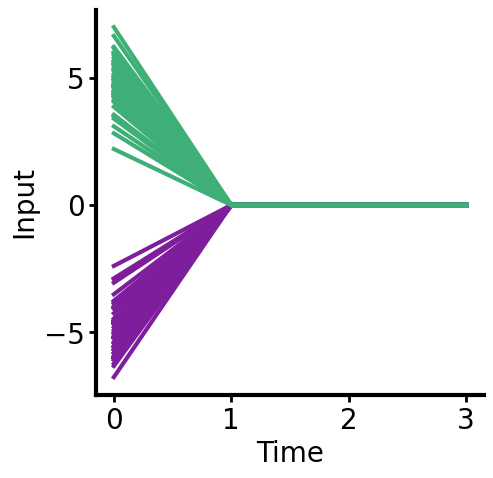

In [3]:
# Generate and plot trials
trials, labels = generate_trials(n_steps=3)
plot_trials(trials=trials, labels=labels)

## Network model

Now we're going to define a simple [recurrent neural network](https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/), and a function for testing it's performance on our task.

---
---


> 2. Read through the ```RecurrentNetwork``` class in src.py. Why do we maintain two sets of ```unit_activations```: ```_t_1``` and ```_t```?

--

Ans : Maintaining  ```_t_1``` and ```_t``` allows the ```RecurrentNetwork``` to track the previous state while updating the current one, which is key for handling time-based tasks in RNNs.

---
---

> 3. Read through the ```test_network``` function below. Why do we use ```argmax``` to generate predictions?

--

Ans : The network outputs probabilities for each class and ```argmax``` picks the index of the highest output value.
Since the network outputs a vector like [0.1, 0.9]. argmax returns 1 to predict class 1

---
---
> 4. Initialise a network, visualise it and test it's performance (fitness). Why does it guess randomly at initialisation?

--

Ans : At startup, the network’s weights are randomly initialized, and there are no connections yet. Without training, it has no learned patterns to make meaningful predictionsso and so it guesses by chance. Performance improves only after evolution.

In [4]:
def test_network(network, trials=trials, labels=labels):
    """
    Tests a network on a set of trials.
    Arguments:
        trials: a numpy array storing the trials (trials, time).
        labels: a numpy vector with a label per trial (trials,).
    Returns:
        fitness: a score between 0 and 1 (perfect performance).
        predictions: the network's predictions per trial.
    """
    outputs = []
    for trial in trials:
        outputs.append(network.forward(trial.reshape(1,-1)))

    predictions = np.argmax(np.array(outputs), axis=1)

    return np.sum(predictions == labels) / len(labels), predictions

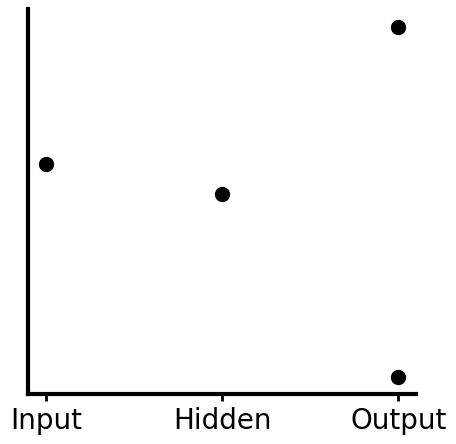

In [5]:
# Initialise a network and visualise it
network = RecurrentNetwork(n_inputs=1, n_hidden=1, n_outputs=2)
plot_architecture(network=network) # note that the network has nodes, but no connections

Fitness = 0.52


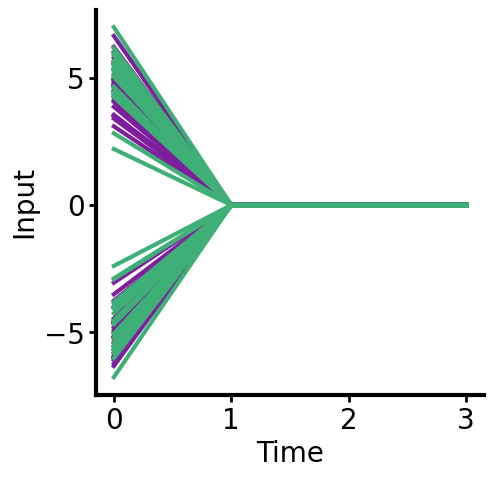

In [6]:
# Test this network's performance (fitness)
fitness, predictions = test_network(network=network)
print("Fitness = " + str(fitness))
plot_trials(trials=trials, labels=predictions) # Note that we're we're coloring each trial by the network's prediction, not it's true label

## Writing an evolutionary algorithm

To optimise our model, we're going to write a simple evolutionary algorithm in 4 steps:

* Generate a population of networks
* Evaluate each network's fitness
* Rank networks by their fitness
* Make a new population by varying the best network(s)

Then, we'll wrap these steps into a function.

---
---

> 5. We'll need the ```add_connections``` function from the ```RecurrentNetwork``` class. How does this work?

--
Ans : It randomly creates connections between nodes (examples are input → hidden, hidden → output), and assigns random weights.
This is how networks are structured before training begins.

---
---

> 6. Have a look at the ```evolve_networks``` function below to see what you're aiming for.

--
The plotted evolve networks shows how they connect input, hidden, and output node

---
---
> 7. Fill in the code cells below, then combine them to make your ```evolve_networks``` function.

In [7]:
# Generate a population of networks
population_size = 10 # the number of networks in each generation
networks = []
for n in range(population_size):
    net = RecurrentNetwork(n_inputs=1, n_hidden=1, n_outputs=2)
    num_connections = np.random.randint(3, 6)
    net.add_connections(num_connections)
    networks.append(net)

    # You may want to create a "diverse" population by adding different numbers of connections to each network
    pass

In [8]:
# Evaluate each network's fitness
fitness = []
for n in range(population_size):
    # Fill in code here
    fit, _ = test_network(network=net)
    fitness.append(fit)

    pass

In [9]:
# Rank network's by their fitness
sorted_indices = np.argsort(fitness)[::-1]
networks = [networks[i] for i in sorted_indices]
fitness = [fitness[i] for i in sorted_indices]


# Track best fitness
num_generations = 20  # or 30
best_fitness_per_generation = []

# If you reach maximum fitness, you could use a break statement here to stop training.
for generation in range(num_generations):
    best_fitness_per_generation.append(fitness[0])

    if best_fitness_per_generation[-1] == 1:
        break


In [10]:
import copy

parent = networks[0]
networks = []
for _ in range(population_size):
    child = copy.deepcopy(parent)
    child.add_connections(np.random.randint(1, 3))
    networks.append(child)


In [11]:
# for generation in range(num_generations):
#     # 1. Make population
#     networks = []
#     for _ in range(population_size):
#         net = RecurrentNetwork(n_inputs=1, n_hidden=1, n_outputs=2)
#         net.add_connections(np.random.randint(3, 6))
#         networks.append(net)

#     # 2. Evaluate
#     fitness = []
#     for net in networks:
#         fit, _ = test_network(network=net)
#         fitness.append(fit)

#     # 3. Rank
#     sorted_indices = np.argsort(fitness)[::-1]
#     networks = [networks[i] for i in sorted_indices]
#     fitness = [fitness[i] for i in sorted_indices]

#     # 4. Track best
#     best_fitness_per_generation.append(fitness[0])
#     if best_fitness_per_generation[-1] == 1:
#         break

#     # 5. Mutate best to make new generation
#     parent = networks[0]
#     networks = []
#     for _ in range(population_size):
#         child = copy.deepcopy(parent)
#         child.add_connections(np.random.randint(1, 3))
#         networks.append(child)


In [12]:
# Now, wrap all of the above code into a function

# I've suggested some inputs and outputs, but you could add others!
num_generations = 50
best_fitness_per_generation = []
def evolve_networks(population_size, i_connections, n_generations):
    """
    Evolves networks to solve a given task.
    Arguments:
        population_size: the number of networks per generation.
        i_connections: connections per network in generation 0.
        n_generations: the number of generations to run.
    Outputs:
        networks: a list of networks from the final generation.
        best_fitness_per_generation: the maximum fitness in each generation.
    """
    # Generate a population of networks
    networks, best_fitness_per_generation = [], []
    for n in range(population_size):
        net = RecurrentNetwork(n_inputs=1, n_hidden=1, n_outputs=2)
        net.add_connections(i_connections)
        networks.append(net)
        pass

    for _ in tqdm(range(n_generations)):
        # Evaluate each network's fitness
        fitness = []
        for net in networks:
            fit, _ = test_network(network=net)
            fitness.append(fit)
            pass

        # Rank networks by their fitness
        sorted_indices = np.argsort(fitness)[::-1]
        networks = [networks[i] for i in sorted_indices]
        fitness = [fitness[i] for i in sorted_indices]
        pass

        best_fitness_per_generation.append(fitness[0])
        if best_fitness_per_generation[-1] == 1:
            break

        # Make a new population by varying the best network(s)
        parent = networks[0]
        networks = []
        for _ in range(population_size):
            child = copy.deepcopy(parent)
            child.add_connections(np.random.randint(1, 3))
            networks.append(child)

        pass

    return networks, best_fitness_per_generation

> 8. Now test your code. If it's working, you should be able to evolve good solutions (with fitness close to 1), using a small population (say 10) and less than 100 generations.

Note: using ```tqdm```, as suggested above, will allow you to estimate your codes run time. If your code is running too slowly, you can interrupt it.

100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


Text(0, 0.5, 'Fitness')

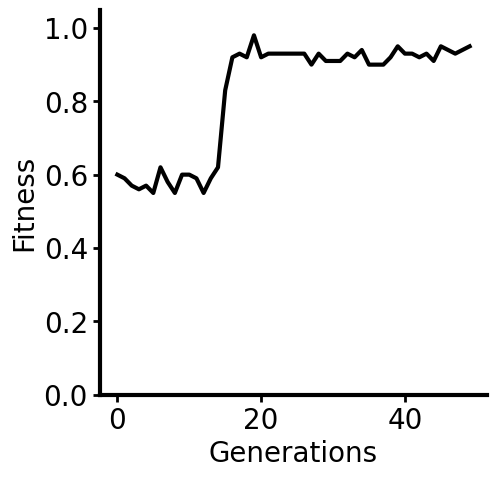

In [13]:
# Testing your function
networks, fitness = evolve_networks(population_size=10, i_connections=0, n_generations = num_generations)

plt.plot(fitness, color='k')
plt.ylim(0.0, 1.05)
plt.xlabel('Generations')
plt.ylabel('Fitness')

> 9. Once you can evolve "good" networks, try to plot some of the evolved architectures - what do they look like?

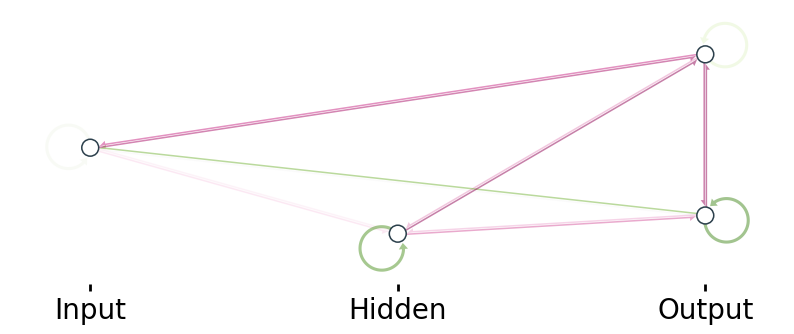

In [14]:
# Ploting evolved architectures
try:
    plot_architecture(network=networks[0])
except:
    plot_architecture(network=network)

## Extensions

Now you have a working evolutionary algorithm, try working on one or two of these extensions (in any order):

> 10. Build on your algorithm. Above, we evolved networks by adding connections. But there are many variations we could use, for example adding nodes, updating weights etc. Try adding these to your algorithm. Hint: the ```RecurrentNetwork``` class already has an ```add_nodes``` function.

> 10. Could your algorithm solve a more complex task? Hint: you could create a more complex task by changing ```generate_trials``` hyperparameter's or modifying the function itself. For example, you could increase ```n_steps``` or pad with noise instead of zeros.

> 10. How do your networks solve the task, do they all use the same solution? Hint: try plotting and comparing some of the evolved architectures.

 10. Build on your algorithm. Above, we evolved networks by adding connections. But there are many variations we could use, for example adding nodes, updating weights etc. Try adding these to your algorithm. Hint: the ```RecurrentNetwork``` class already has an ```add_nodes``` function.

In [15]:
'''

 Build on your algorithm. Above, we evolved networks by adding connections.
 But there are many variations we could use, for example adding nodes, updating weights etc.
 Try adding these to your algorithm. Hint: the ```RecurrentNetwork``` class already has an
 ```add_nodes``` function.

'''


import copy
from tqdm import tqdm

def evolve_networks(population_size, i_connections, n_generations):
    """
    Evolves networks to solve a given task.

    Arguments:
        population_size: number of networks in each generation.
        i_connections: initial connections for each network.
        n_generations: number of generations to run.

    Returns:
        networks: list of networks from the final generation.
        best_fitness_per_generation: best fitness score in each generation.
    """

    # Initialise population and tracking
    networks, best_fitness_per_generation = [], []

    # Generation 0: random population with i_connections
    for _ in range(population_size):
        net = RecurrentNetwork(n_inputs=1, n_hidden=1, n_outputs=2)
        net.add_connections(i_connections)
        networks.append(net)

    # Evolution loop
    for _ in tqdm(range(n_generations)):

        # Evaluate each network
        fitness = []
        for net in networks:
            fit, _ = test_network(network=net)
            fitness.append(fit)

        # Rank networks by fitness
        sorted_indices = np.argsort(fitness)[::-1]
        networks = [networks[i] for i in sorted_indices]
        fitness = [fitness[i] for i in sorted_indices]

        # Track and check best fitness
        best_fitness_per_generation.append(fitness[0])
        if best_fitness_per_generation[-1] == 1:
            break

        # Make new population from best network with mutation
        parent = networks[0]
        networks = []
        for _ in range(population_size):
            child = copy.deepcopy(parent)
            child.add_connections(np.random.randint(1, 3))  # mutate connections

            #  mutate by adding nodes (sometimes)
            if np.random.rand() < 0.5:
                child.add_nodes(np.random.randint(1, 2))  # 50% chance to add 1 node

            networks.append(child)

    return networks, best_fitness_per_generation




In [16]:
# Generate the data
trials, labels = generate_trials(n_steps=3)

# Run evolution
networks, fitness_history = evolve_networks(
    population_size=10,
    i_connections=5,
    n_generations=40
)

# Print final fitness
print("Best fitness per generation:", fitness_history)
print("Final best fitness:", fitness_history[-1])

# Test the final best network
best_net = networks[0]
final_fitness, predictions = test_network(best_net, trials=trials, labels=labels)
print("Final network performance:", final_fitness)



 68%|██████▊   | 27/40 [00:33<00:16,  1.23s/it]


Best fitness per generation: [np.float64(0.82), np.float64(0.89), np.float64(0.95), np.float64(0.95), np.float64(0.93), np.float64(0.95), np.float64(0.96), np.float64(0.93), np.float64(0.94), np.float64(0.95), np.float64(0.94), np.float64(0.94), np.float64(0.99), np.float64(0.98), np.float64(0.98), np.float64(0.99), np.float64(0.98), np.float64(0.98), np.float64(0.99), np.float64(0.99), np.float64(0.99), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.99), np.float64(1.0)]
Final best fitness: 1.0
Final network performance: 0.98


100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


Text(0, 0.5, 'Fitness')

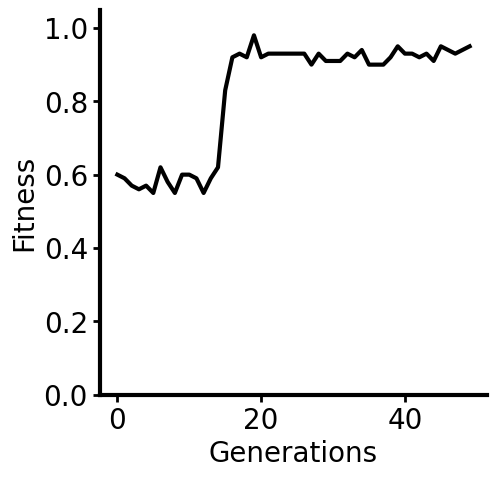

In [17]:
# Test function
networks, final_fitness = evolve_networks(population_size=10, i_connections=0, n_generations = num_generations)

plt.plot(fitness, color='k')
plt.ylim(0.0, 1.05)
plt.xlabel('Generations')
plt.ylabel('Fitness')

<Figure size 900x900 with 0 Axes>

<Figure size 500x500 with 0 Axes>

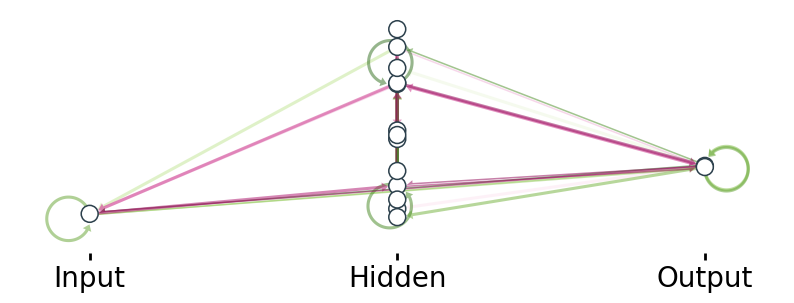

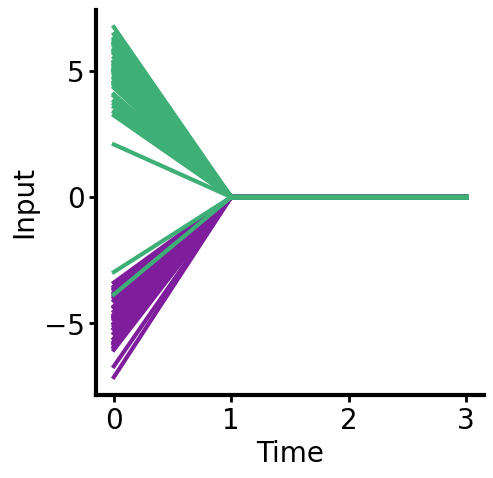

In [18]:
import matplotlib.pyplot as plt

# # Set up a nicer, wider figure
# plt.figure(figsize=(6, 3))  # wider instead of tall
# plot_architecture(network=best_net)
# plt.tight_layout()
# plt.show()

# # Plot predictions vs inputs
# plt.figure(figsize=(6, 4))
# plot_trials(trials=trials, labels=predictions)
# plt.title("Network predictions")
# plt.xlabel("Time")
# plt.ylabel("Input")
# plt.tight_layout()
# plt.show()


plt.figure(figsize=(9, 9))  # make square

plt.figure(figsize=(5, 5))  # 👈 Add this
plot_architecture(network=best_net)

plt.figure(figsize=(5, 5))  # 👈 Add this too
plot_trials(trials=trials, labels=predictions)


 10. Could your algorithm solve a more complex task? Hint: you could create a more complex task by changing ```generate_trials``` hyperparameter's or modifying the function itself. For example, you could increase ```n_steps``` or pad with noise instead of zeros.

In [19]:
def generate_trials_with_noise(n_steps, mean_per_class=[-5, 5], n_trials_per_class=50):
    """
    Generates trials with random noise padding after time 0.
    """
    trials, labels = [], []
    for a, mean in enumerate(mean_per_class):
        x0 = np.random.normal(loc=mean, scale=1, size=n_trials_per_class)
        noise = np.random.normal(loc=0, scale=1, size=(n_trials_per_class, n_steps))
        x = np.concatenate([x0[:, None], noise], axis=1)  # shape: (trials, n_steps+1)
        trials.append(x)
        labels.append(np.full(n_trials_per_class, a))

    return np.vstack(trials), np.concatenate(labels)


In [20]:
# Generate more complex data
trials, labels = generate_trials_with_noise(n_steps=5)

# Evolve networks on the harder task
networks, fitness_history = evolve_networks(
    population_size=10,
    i_connections=5,
    n_generations=40
)

# Print and evaluate
print("Best fitness per generation:", fitness_history)
print("Final best fitness:", fitness_history[-1])

# Test final network
best_net = networks[0]
final_fitness, predictions = test_network(best_net, trials=trials, labels=labels)
print("Final network performance:", final_fitness)




100%|██████████| 40/40 [01:15<00:00,  1.90s/it]


Best fitness per generation: [np.float64(0.6), np.float64(0.56), np.float64(0.59), np.float64(0.62), np.float64(0.51), np.float64(0.56), np.float64(0.62), np.float64(0.58), np.float64(0.66), np.float64(0.67), np.float64(0.69), np.float64(0.75), np.float64(0.79), np.float64(0.79), np.float64(0.75), np.float64(0.76), np.float64(0.79), np.float64(0.72), np.float64(0.78), np.float64(0.8), np.float64(0.84), np.float64(0.8), np.float64(0.8), np.float64(0.77), np.float64(0.83), np.float64(0.77), np.float64(0.81), np.float64(0.78), np.float64(0.78), np.float64(0.91), np.float64(0.93), np.float64(0.94), np.float64(0.93), np.float64(0.91), np.float64(0.9), np.float64(0.9), np.float64(0.94), np.float64(0.93), np.float64(0.93), np.float64(0.92)]
Final best fitness: 0.92
Final network performance: 0.47


<Figure size 900x900 with 0 Axes>

<Figure size 500x500 with 0 Axes>

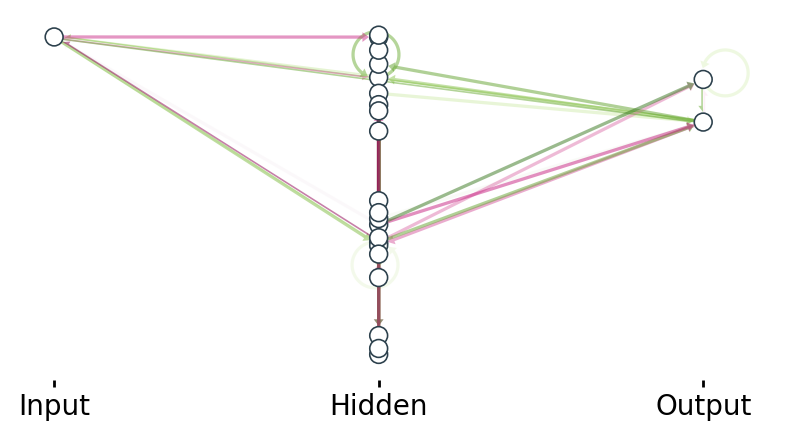

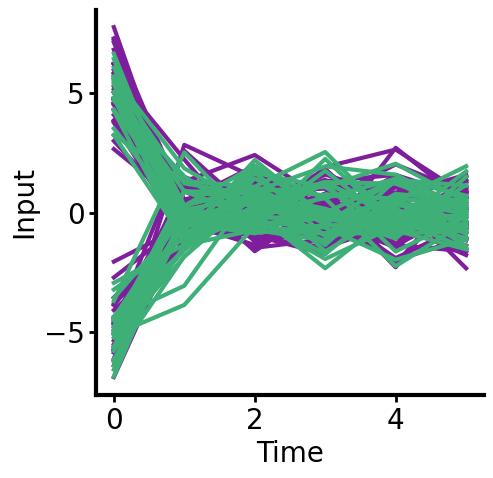

In [21]:
# Visualize

plt.figure(figsize=(9, 9))  # make square

plt.figure(figsize=(5, 5))  # 👈 Add this
plot_architecture(network=best_net)

plt.figure(figsize=(5, 5))  # 👈 Add this too
plot_trials(trials=trials, labels=predictions)
